No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


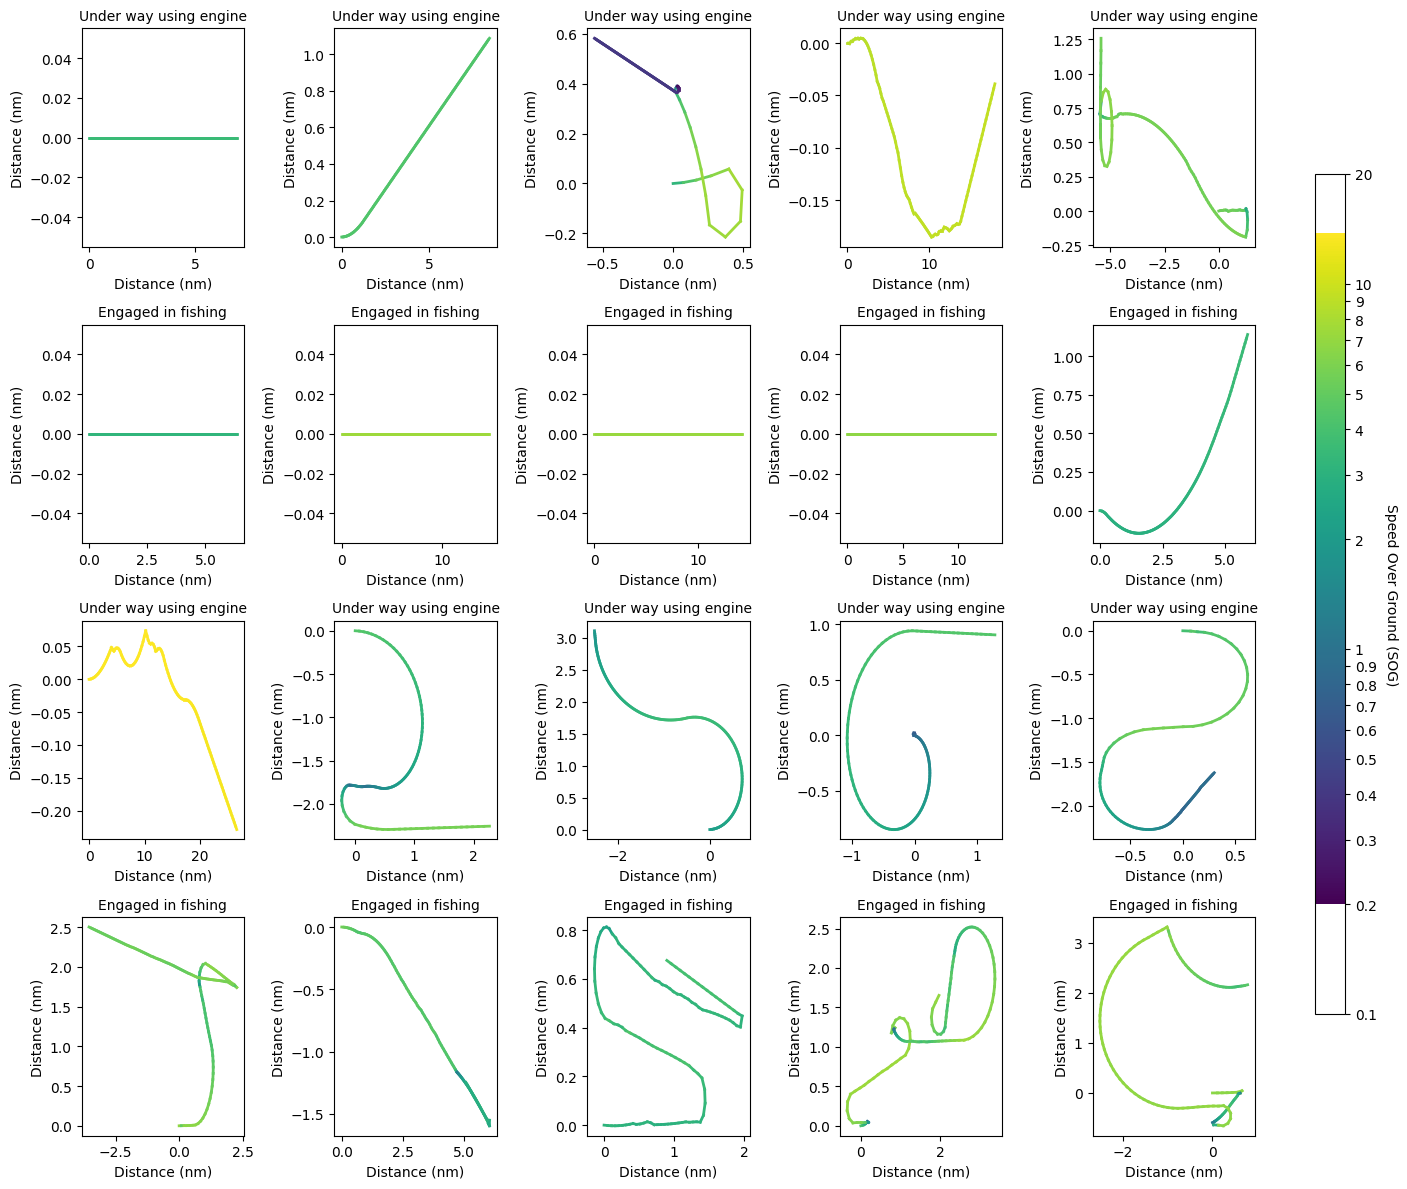

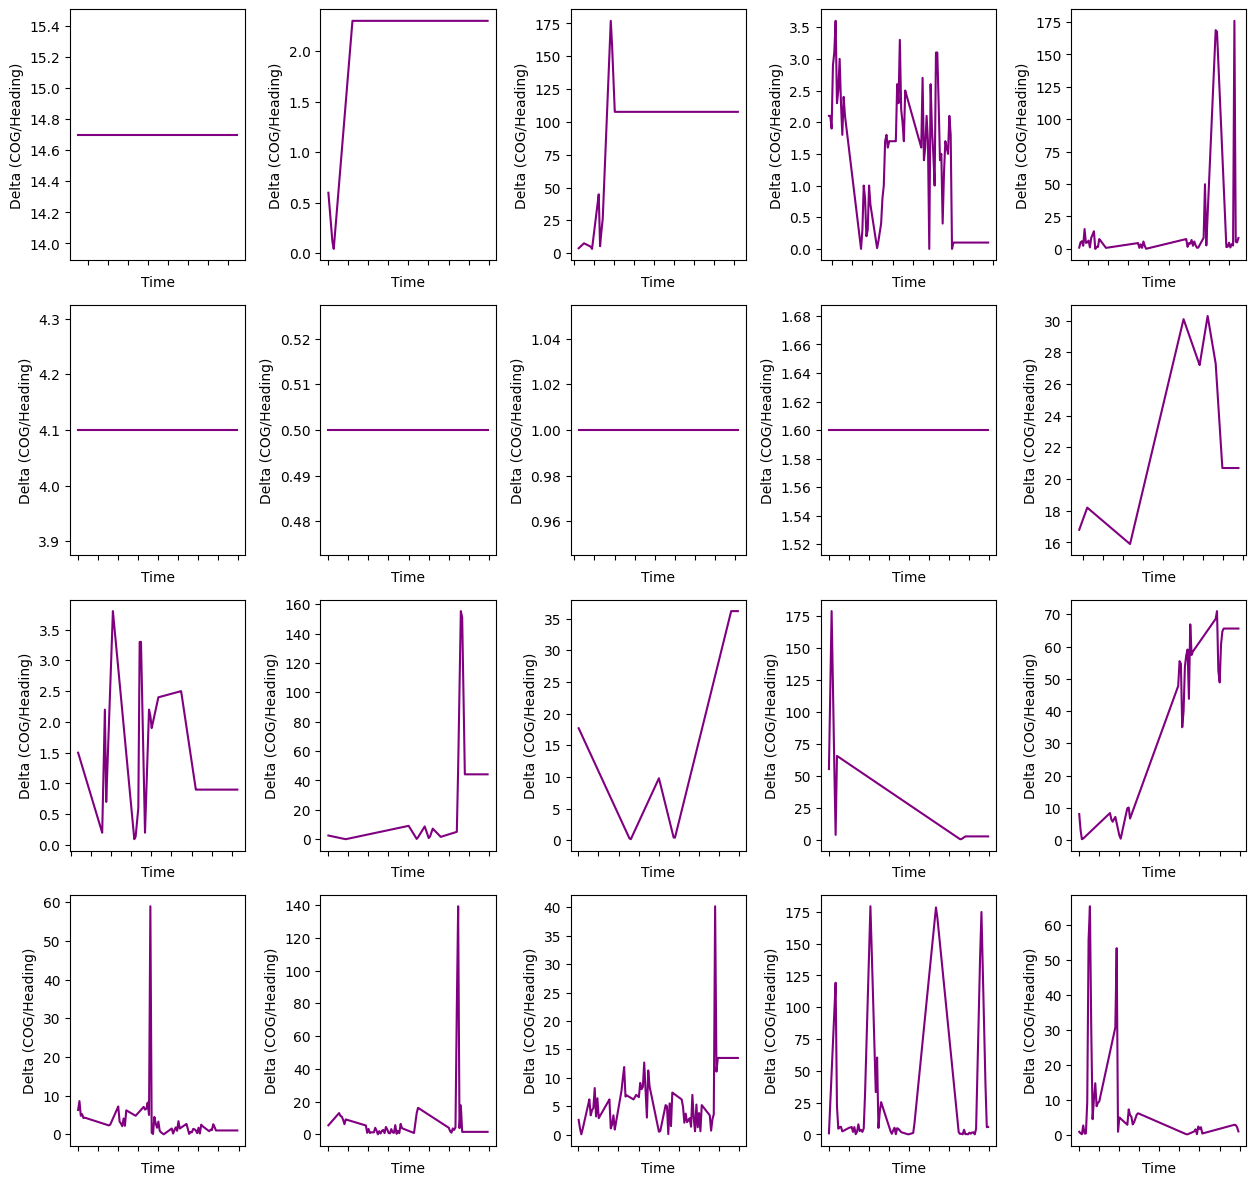

Visualization completed for balanced classes of misclassified and correctly classified files, including delta COG-Heading with cyclical correction.


C:\Users\goeck\AppData\Local\Temp\ipykernel_10700\2346140371.py:171: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_delta.show()


In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

# Define paths
misclassified_file = "2h_LSTM_2_2_misclassified_summary_99.csv"
input_folder = "../5_Data_Pipeline/time_sets_st_shortened"

# Read misclassified summary and get the top 10 misclassified files
df_misclassified = pd.read_csv(misclassified_file)
df_misclassified_sorted = df_misclassified.sort_values(by="misclassified", ascending=False)

# Separate misclassified files into two groups based on navigational status
misclassified_ue = []  # Under way using engine
misclassified_ef = []  # Engaged in fishing
for file_name in df_misclassified_sorted["file"].tolist():
    file_path = os.path.join(input_folder, file_name)
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        status = data['Navigational status'].iloc[0] if 'Navigational status' in data.columns else 'Unknown'
        if status == "Under way using engine" and len(misclassified_ue) < 5:
            misclassified_ue.append(file_name)
        elif status == "Engaged in fishing" and len(misclassified_ef) < 5:
            misclassified_ef.append(file_name)
        if len(misclassified_ue) == 5 and len(misclassified_ef) == 5:
            break  # Stop once we've reached 5 vessels in each category

# Separate correctly classified files into two groups based on navigational status
correctly_classified_ue = []  # Under way using engine
correctly_classified_ef = []  # Engaged in fishing
for file_name in df_misclassified_sorted[::-1]["file"].tolist():  # Start from the bottom of the sorted list
    file_path = os.path.join(input_folder, file_name)
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        status = data['Navigational status'].iloc[0] if 'Navigational status' in data.columns else 'Unknown'
        if status == "Under way using engine" and len(correctly_classified_ue) < 5:
            correctly_classified_ue.append(file_name)
        elif status == "Engaged in fishing" and len(correctly_classified_ef) < 5:
            correctly_classified_ef.append(file_name)
        if len(correctly_classified_ue) == 5 and len(correctly_classified_ef) == 5:
            break  # Stop once we've reached 5 vessels in each category

# Combine all selected files
all_files = misclassified_ue + misclassified_ef + correctly_classified_ue + correctly_classified_ef

# Compute global SOG range
global_min_sog, global_max_sog = float("inf"), float("-inf")
for file_name in all_files:
    file_path = os.path.join(input_folder, file_name)
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        if 'SOG' in data.columns:
            global_min_sog = min(global_min_sog, data['SOG'].min())
            global_max_sog = max(global_max_sog, data['SOG'].max())

# Ensure valid min/max SOG values
global_min_sog = max(global_min_sog, 0.1)
global_max_sog = max(global_max_sog, 1.0)

# Set up colormap
norm = LogNorm(vmin=global_min_sog, vmax=global_max_sog)
cmap = plt.cm.viridis
sm = ScalarMappable(cmap=cmap, norm=norm)

# Function to calculate angular difference with wraparound (cyclical difference)
def angular_diff(cog, heading):
    diff = np.abs(cog - heading)  # Initial difference
    return np.minimum(diff, 360 - diff)  # Wrap around if the difference exceeds 180°

def visualize_vessel_path(file_path, status, ax, ax_delta):
    try:
        data = pd.read_csv(file_path)
        if not {'Timestamp', 'SOG', 'COG', 'Navigational status', 'Heading'}.issubset(data.columns):
            print(f"Skipping {file_path}: Missing required columns.")
            return
        
        # Convert timestamp
        data['Timestamp'] = pd.to_datetime(data['Timestamp'])
        data['time_diff'] = data['Timestamp'].diff().dt.total_seconds() / 3600
        data.loc[0, 'time_diff'] = 0
        
        # Compute relative positions
        data['x'] = data['SOG'] * data['time_diff'] * np.cos(np.deg2rad(data['COG']))
        data['y'] = data['SOG'] * data['time_diff'] * np.sin(np.deg2rad(data['COG']))
        data['x_cum'], data['y_cum'] = data['x'].cumsum(), data['y'].cumsum()
        
        # Plot vessel path
        for i in range(len(data) - 1):
            ax.plot(
                [data['x_cum'].iloc[i], data['x_cum'].iloc[i + 1]],
                [data['y_cum'].iloc[i], data['y_cum'].iloc[i + 1]],
                color=cmap(norm(data['SOG'].iloc[i])),
                linewidth=2
            )
        
        # Calculate the delta between COG and Heading using the angular_diff function
        data['delta_COG_Heading'] = angular_diff(data['COG'], data['Heading'])
        
        # Check for cases where delta COG/Heading > 50 degrees and print the filenames
        if (data['delta_COG_Heading'] > 50).any():
            print(f"Warning: Delta COG/Heading > 50 for file: {file_path}")

        # Plot delta COG and Heading on the secondary axis
        ax_delta.plot(data['Timestamp'], data['delta_COG_Heading'], color='purple')
        ax_delta.set_ylabel('Delta (COG/Heading)')  # Keep y-axis label for clarity but can remove if not needed
        ax_delta.set_xlabel('Time', fontsize=10)  # Add "Time" label to the x-axis

        # Labels and title for main plot
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel('Distance (nm)')
        ax.set_title(f"{status}", fontsize=10)

        # Keep the "Time" label intact but hide the x-axis tick labels (numbers)
        ax_delta.set_xticklabels([])  # Remove x-axis numerical labels (but keep ticks)
        
        # Remove the legend
        ax_delta.legend().set_visible(False)
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Create subplots for multiple images
cols = 5
rows = 4  # Two rows for misclassified and two rows for correctly classified
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()

# Create a secondary axis for the delta COG and Heading plots
fig_delta, axes_delta = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes_delta = axes_delta.flatten()

for idx, file_name in enumerate(all_files):
    if idx >= len(axes):
        break  # Avoid accessing non-existent subplot axes
    
    input_path = os.path.join(input_folder, file_name)
    if not os.path.exists(input_path):
        print(f"File not found: {input_path}")
        continue
    
    data = pd.read_csv(input_path)
    status = data['Navigational status'].iloc[0] if 'Navigational status' in data.columns else 'Unknown'
    
    visualize_vessel_path(input_path, status, axes[idx], axes_delta[idx])

# Remove unused subplots
for idx in range(len(all_files), len(axes)):
    fig.delaxes(axes[idx])
for idx in range(len(all_files), len(axes_delta)):
    fig_delta.delaxes(axes_delta[idx])

# Adjust layout to prevent overlap
fig.tight_layout(rect=[0, 0, 0.85, 1])
fig_delta.tight_layout(rect=[0, 0, 0.85, 1])

# Add colorbar
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Speed Over Ground (SOG)', rotation=270, labelpad=15)

# Custom ticks for the colorbar
ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:g}" for t in ticks])

# Show the figures
plt.show()
fig_delta.show()

print("Visualization completed for balanced classes of misclassified and correctly classified files, including delta COG-Heading with cyclical correction.")